In [3]:
# Copied from my assignment 6
# Read in data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.optimize import linprog

def getData(path):
    data = []
    with open(path) as f:
        for line in f:
            l = line.split()

            if len(l) < 256:
                continue
            label = int(float(l[0]))

            if label == 1 or label == 5:
                #Convert to float
                pixels = [float(p) for p in l[1:]]
                image = np.reshape(pixels, (-1, 16))
                data.append((label, image))
    return data

In [4]:
# Copied features from assignment 6
def sym(data):
    sym = 0
    for i in range(15):
        j = 0
        k = 15
        while j < k:
            diff = data[i][j] - data[i][k]
            if diff == 0:
                sym +=1
            j +=1
            k -=1
    return sym

def intense(data):
    return np.sum(data)

In [5]:
# Change data to pd.DataFrame format using features to find x, y values
# Modified testFeatures from Assignment 6
def convertData(data):
    converted = []
    for num, img in data:
        in_res = intense(img)
        sym_res = sym(img)
        converted.append({
            'x': in_res,
            'y': sym_res,
            'label': 1 if num == 1 else -1
        })
    df = pd.DataFrame(converted)
    return df 

In [4]:
# lin reg function from assignment 6
def linReg(df):
    X = df[['x', 'y']].values
    y = df['label'].values

    X = np.hstack([np.ones((X.shape[0], 1)), X])
    
    #Compute weights = (X^T X)^(-1) X^T y
    XtX = X.T @ X
    Xty = X.T @ y
    weights = np.linalg.inv(XtX) @ Xty

    return weights

In [44]:
# Modified PLA from assignment 1
# Added starting weight from lin reg and limit of updates
def pocket(startWeight, df, maxUpdates):
    labels = df['label'].values               
    points = df[['x', 'y']].values
    currWeights = np.array(startWeight, dtype=float)
    bestWeights = np.array(startWeight, dtype=float)
    updates = 0

    allPoints = np.c_[np.ones(len(points)), points]
    pred = np.sign(np.dot(allPoints, currWeights))
    bestCorrect = np.sum(pred == labels)
    
    while updates < maxUpdates:
        updated = False
        for i in range(len(points)):
            x = np.array([1, points[i][0], points[i][1]])
            label = labels[i]

            #if any misclass -> update weights and check if better than current best
            if np.dot(currWeights, x) * label <= 0:
                currWeights += label * x
                updates += 1
                updated = True

                #count num classified correctly
                allPoints = np.c_[np.ones(len(points)), points]
                pred = np.sign(np.dot(allPoints, currWeights))
                correct = np.sum(pred == labels)

                if correct > bestCorrect:
                    bestCorrect = correct
                    bestWeights = currWeights.copy()
                break
        if not updated:
            break

    return bestWeights, bestCorrect, updates

In [103]:
def gradient(startWeight, df, maxUpdates, rate):
    labels = df['label'].values               
    points = df[['x', 'y']].values
    weights = np.array(startWeight, dtype=float)
    allPoints = np.c_[np.ones(len(points)), points]

    for update in range(maxUpdates):
        grad = np.zeros(3)
        for i in range(len(allPoints)):
            x = allPoints[i]
            y = labels[i]
            conf = y * np.dot(weights, x)
            
            #if not good enough -> gradient
            if conf < 1:
                gradient += -y * x  
        grad /= len(allPoints)
        weights -= rate * grad
    pred = np.sign(np.dot(allPoints, weights))
    correct = np.sum(pred == labels)
    return weights, correct

In [148]:
def stochastic(startWeight, df, maxUpdates, rate):
    labels = df['label'].values               
    points = df[['x', 'y']].values
    weights = np.array(startWeight, dtype=float)
    allPoints = np.c_[np.ones(len(points)), points]
    updates = 0
    i = 0
    n = len(allPoints)
    
    while updates < maxUpdates:
        x = allPoints[i]
        y = labels[i]
        conf = y * np.dot(weights, x)
        
        if conf < 1:
            grad = -y * x
            weights -= rate * grad
            updates += 1
        i = (i + 1) % n
    pred = np.sign(np.dot(allPoints, weights))
    correct = np.sum(pred == labels)
    return weights, correct

In [171]:
#uses scipy's linprog() 
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html
#https://www.tutorialspoint.com/scipy/scipy_optimize_linprog_function.htm
#https://www.geeksforgeeks.org/python/maximize-optimization-using-scipy/

def linProgram(df):
    points = df[['x', 'y']].values
    labels = df['label'].values
    allPoints = np.c_[np.ones(len(points)), points]
    n = len(allPoints)
    weights = np.zeros(3)
    A = np.zeros((n, n+3))
    b = -np.ones(n)
    c = np.hstack([np.zeros(3), 1 * np.ones(n)])
    bounds = [(None, None)] * 3 + [(0, None)] * n
    for i in range(n):
        A[i, 0:3] = -labels[i] * allPoints[i]
        A[i, 3 + i] = -1

    #min c subject to A, b, bounds
    result = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='highs')
    if result.success:
        weights = result.x[0:3]
        pred = np.sign(np.dot(allPoints, weights))
        correct = np.sum(pred == labels)
        return weights, correct
    else:
        raise ValueError("Failed")

In [135]:
#Calculates number of correctly categorized data on test data based on training data's separator
def testing(df, weights):
    points = df[['x', 'y']].values
    labels = df['label'].values
    allPoints = np.c_[np.ones(len(points)), points]
    pred = np.sign(np.dot(allPoints, weights))
    return np.sum(pred == labels) 

In [123]:
def plotting(df, test, error, title, bestWeights, save):
    df1 = df[df['label'] == 1]
    plt.plot(df1['x'], df1['y'], 'bo', alpha=0.3, label='1')
    df5 = df[df['label'] == -1]
    plt.plot(df5['x'], df5['y'], 'rx', alpha=0.3, label='5')

    xVals = np.linspace(df['x'].min(), df['x'].max(), 100)
    yVals = -(bestWeights[0] + bestWeights[1] * xVals) / (bestWeights[2])
    plt.plot(xVals, yVals, 'k--', label='Decision boundary')

    if test == False:
        plt.figtext(0,0, f"Training Error: {error}")
    if test == True:
        plt.figtext(0,0, f"Test Error: {error}")
    
    plt.xlabel("Intensity")
    plt.ylabel("Symmetry (horizontal)")
    plt.title(title)
    plt.legend()
    plt.savefig(save)
    plt.show()

In [9]:
def error(size, correct):
    wrong = size-correct
    return wrong/size

In [10]:
def hoeff(Ein, N, delta=0.05):
    epsilon = math.sqrt((1/(2*N)) * math.log(2/delta))
    Eout = Ein + epsilon
    return Eout

In [6]:
# Read and convert data
train = getData("handwriting\data.train")
test = getData("handwriting\data.test")

dfTrain = convertData(train)
dfTest = convertData(test)

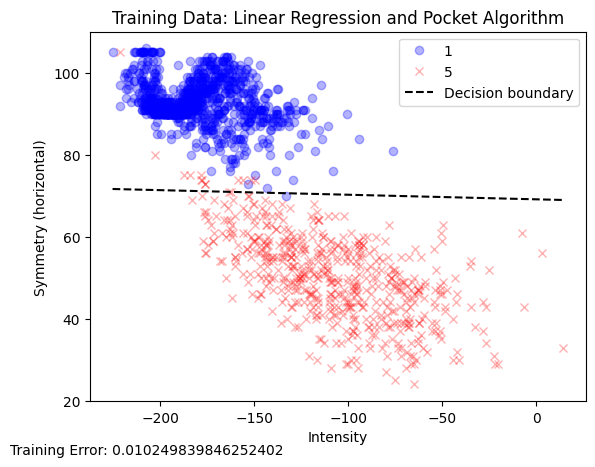

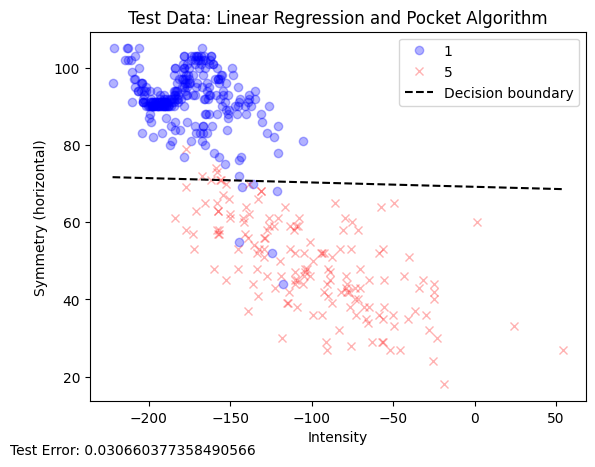

In [136]:
# Question 1
# Linear Regression -> Pocket Alg
trainWeight, trainCorrect, trainUpdates = pocket(linReg(dfTrain), dfTrain, 10000)
Etrain = error(dfTrain['x'].size, trainCorrect)
#print(trainWeight, trainCorrect, trainUpdates)
#print(Etrain)
testCorrect = testing(dfTest, trainWeight)
Etest = error(dfTest['x'].size, testCorrect)
#print(testWeight, testCorrect, testUpdates)

plotting(dfTrain, False, Etrain, "Training Data: Linear Regression and Pocket Algorithm", trainWeight, "LinRegPocketTrain")
plotting(dfTest, True, Etest, "Test Data: Linear Regression and Pocket Algorithm", trainWeight, "LinRegPocketTest")

[-2.91294533e+00  1.34285684e-03  4.63027827e-02] 1532
[-2.66687784  0.00565011  0.04731578] 408


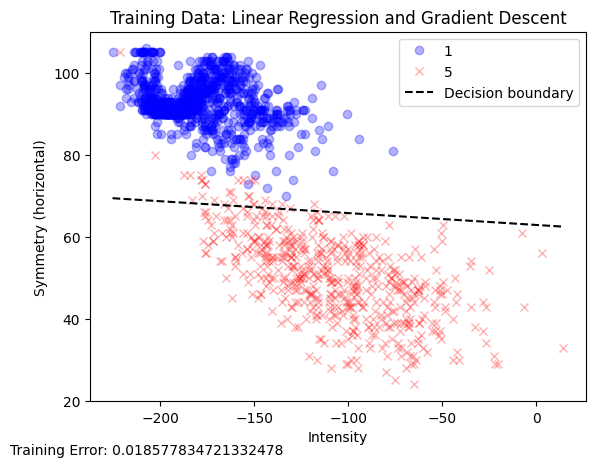

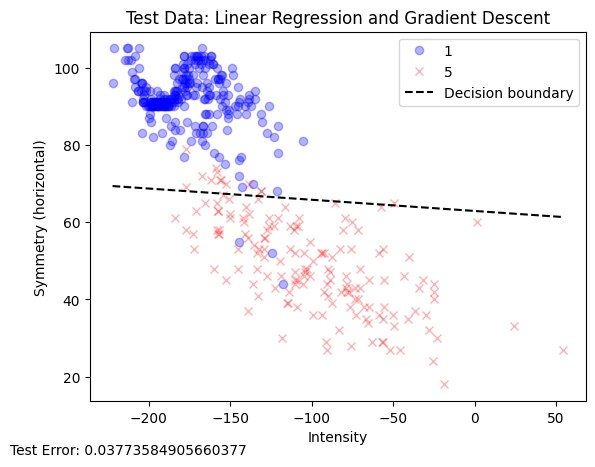

In [146]:
# Linear Regression -> Gradient Descent 
trainWeight, trainCorrect = gradient(linReg(dfTrain), dfTrain, 5000, .000001)
Etrain = error(dfTrain['x'].size, trainCorrect)
testCorrect = testing(dfTest, trainWeight)
Etest = error(dfTest['x'].size, testCorrect)
print(trainWeight, trainCorrect)
print(testWeight, testCorrect)

plotting(dfTrain, False, Etrain, "Training Data: Linear Regression and Gradient Descent", trainWeight, "LinRegGradientTrain")
plotting(dfTest, True, Etest, "Test Data: Linear Regression and Gradient Descent", trainWeight, "LinRegGradientTest")

[-2.91354126  0.00335167  0.048874  ] 1544
[-2.66687784  0.00565011  0.04731578] 409


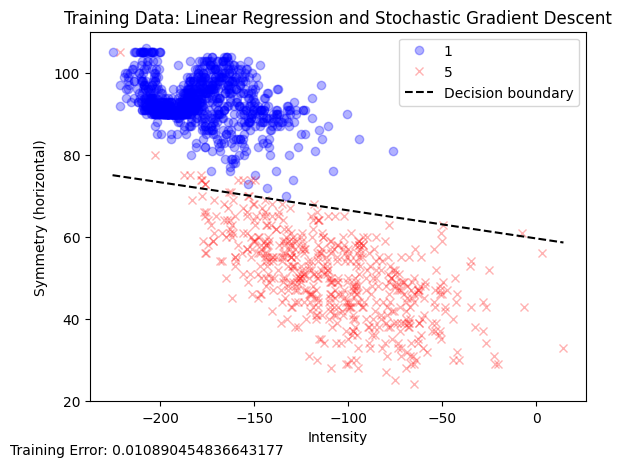

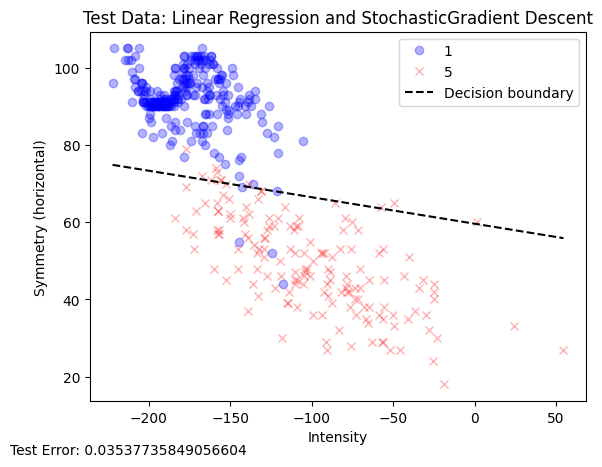

In [145]:
# Linear Regression -> STG
trainWeight, trainCorrect = stochastic(linReg(dfTrain), dfTrain, 5000, .000001)
Etrain = error(dfTrain['x'].size, trainCorrect)
testCorrect = testing(dfTest, trainWeight)
Etest = error(dfTest['x'].size, testCorrect)
print(trainWeight, trainCorrect)
print(testWeight, testCorrect)

plotting(dfTrain, False, Etrain, "Training Data: Linear Regression and Stochastic Gradient Descent", trainWeight, "LinRegStochasticTrain")
plotting(dfTest, True, Etest, "Test Data: Linear Regression and StochasticGradient Descent", trainWeight, "LinRegStochasticTest")

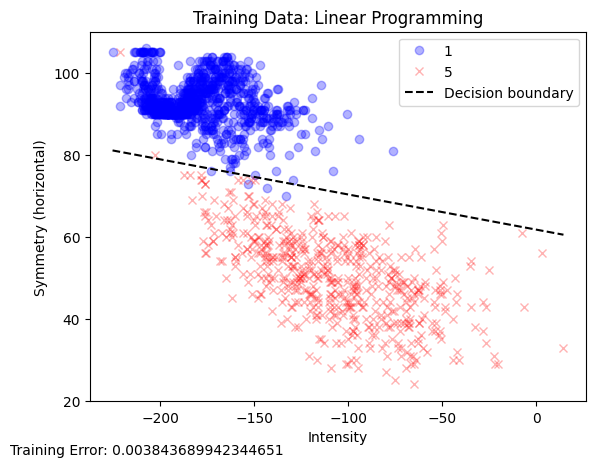

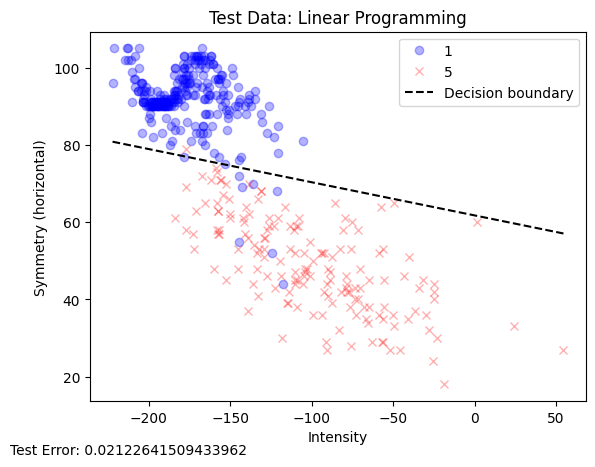

In [181]:
# Linear Programming
trainWeight, trainCorrect = linProgram(dfTrain)
Etrain = error(dfTrain['x'].size, trainCorrect)
testCorrect = testing(dfTest, trainWeight)
Etest = error(dfTest['x'].size, testCorrect)

plotting(dfTrain, False, Etrain, "Training Data: Linear Programming", trainWeight, "LinProgTrain")
plotting(dfTest, True, Etest, "Test Data: Linear Programming", trainWeight, "LinProgTest")

In [182]:
#Part C and D
#Linear Program has best E_train and E_test

Eout1 = hoeff(Etrain, dfTrain['x'].size)
Eout2 = hoeff(Etest, dfTest['x'].size)

print(f"E_train Out-of-sample Error Bound: {Eout1}")
print(f"E_test Out-of-sample Error Bound: {Eout2}")

E_train Out-of-sample Error Bound: 0.03821774611884153
E_test Out-of-sample Error Bound: 0.08718165518858138


In [36]:
# Part E
# 3rd order polynomial transform
from sklearn.preprocessing import PolynomialFeatures
#https://scikit-learn.org/stable/modules/preprocessing.html#generating-polynomial-features

def polyTrans(df, degree):
    x = df[['x', 'y']].values
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    xPoly = poly.fit_transform(x)
    names = poly.get_feature_names_out(['x', 'y'])
    dfPoly = pd.DataFrame(xPoly, columns=names)
    dfPoly['label'] = df['label'].values

    return dfPoly, poly

# Modified functions so they're not hard-coded for w0, w1, w2
def linRegPoly(dfPoly):
    features = [col for col in dfPoly.columns if col != 'label']
    X = dfPoly[features].values
    y = dfPoly['label'].values

    XtX = X.T @ X
    Xty = X.T @ y
    I = np.eye(X.shape[1])
    weights = np.linalg.inv(XtX) @ Xty

    return weights

def pocketPoly(startWeight, dfPoly, maxUpdates):
    labels = dfPoly['label'].values               
    features = [col for col in dfPoly.columns if col != 'label']
    points = dfPoly[features].values
    currWeights = np.array(startWeight, dtype=float)
    bestWeights = np.array(startWeight, dtype=float)
    updates = 0

    pred = np.sign(np.dot(points, currWeights))
    bestCorrect = np.sum(pred == labels)
    
    while updates < maxUpdates:
        updated = False
        for i in range(len(points)):
            x = points[i]
            y = labels[i]

            #if any misclass -> update weights and check if better than current best
            if np.dot(currWeights, x) * y <= 0:
                currWeights += y * x
                updates += 1
                updated = True
                pred = np.sign(np.dot(points, currWeights))
                correct = np.sum(pred == labels)

                if correct > bestCorrect:
                    bestCorrect = correct
                    bestWeights = currWeights.copy()
                break
        if not updated:
            break

    return bestWeights, bestCorrect, updates

def gradientPoly(startWeight, dfPoly, maxUpdates, rate):
    labels = dfPoly['label'].values               
    features = [col for col in dfPoly.columns if col != 'label']
    points = dfPoly[features].values
    weights = np.array(startWeight, dtype=float)

    for update in range(maxUpdates):
        #all 0 array of weight's shape
        grad = np.zeros_like(weights) 
        for i in range(len(points)):
            x = points[i]
            y = labels[i]
            conf = y * np.dot(weights, x)
            
            #if not good enough -> gradient
            if conf < 1:
                grad += -y * x  
        grad /= len(points)
        weights -= rate * grad
    pred = np.sign(np.dot(points, weights))
    correct = np.sum(pred == labels)
    return weights, correct

def stochasticPoly(startWeight, dfPoly, maxUpdates, rate):
    labels = dfPoly['label'].values               
    features = [col for col in dfPoly.columns if col != 'label']
    points = dfPoly[features].values
    weights = np.array(startWeight, dtype=float)
    updates = 0
    i = 0
    n = len(points)
    
    while updates < maxUpdates:
        x = points[i]
        y = labels[i]
        conf = y * np.dot(weights, x)
        
        if conf < 1:
            grad = -y * x
            weights -= rate * grad
            updates += 1
        i = (i + 1) % n
    pred = np.sign(np.dot(points, weights))
    correct = np.sum(pred == labels)
    return weights, correct

def linProgramPoly(dfPoly):
    labels = dfPoly['label'].values
    features = [col for col in dfPoly.columns if col != 'label']
    points = dfPoly[features].values
    nSamples, nFeatures = points.shape
    weights = np.zeros(nFeatures)
    
    A = np.zeros((nSamples, nSamples+nFeatures))
    b = -np.ones(nSamples)
    c = np.hstack([np.zeros(nFeatures), np.ones(nSamples)])
    bounds = [(None, None)] * nFeatures + [(0, None)] * nSamples
    
    for i in range(len(points)):
        A[i, 0:nFeatures] = -labels[i] * points[i]
        A[i, nFeatures + i] = -1

    #min c subject to A, b, bounds
    result = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='highs')
    if result.success:
        weights = result.x[0:nFeatures]
        pred = np.sign(np.dot(points, weights))
        correct = np.sum(pred == labels)
        return weights, correct
    else:
        raise ValueError("Failed")

# Sorry my code is getting messier, I'm losing my mind
def testingPoly(dfPoly, weights):
    features = [col for col in dfPoly.columns if col != 'label']
    points = dfPoly[features].values
    labels = dfPoly['label'].values
    pred = np.sign(np.dot(points, weights))
    return np.sum(pred == labels) 

# Uses sklearn
def plottingPoly(df, test, error, title, bestWeights, save, poly):
    df1 = df[df['label'] == 1]
    plt.plot(df1['x'], df1['y'], 'bo', alpha=0.3, label='1')
    df5 = df[df['label'] == -1]
    plt.plot(df5['x'], df5['y'], 'rx', alpha=0.3, label='5')

    x_min, x_max = df['x'].min() - 1, df['x'].max() + 1
    y_min, y_max = df['y'].min() - 1, df['y'].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_transformed = poly.transform(grid_points)
    Z = np.dot(grid_transformed, bestWeights)
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='dashed', linewidths=2, label='Decision boundary')

    if test == False:
        plt.figtext(0,0, f"Training Error: {error}")
    if test == True:
        plt.figtext(0,0, f"Test Error: {error}")
    
    plt.xlabel("Intensity")
    plt.ylabel("Symmetry (horizontal)")
    plt.title(title)
    plt.legend()
    plt.savefig(save)
    plt.show()

C:\Users\huang\AppData\Local\Temp\ipykernel_41900\1477967418.py:159: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='dashed', linewidths=2, label='Decision boundary')


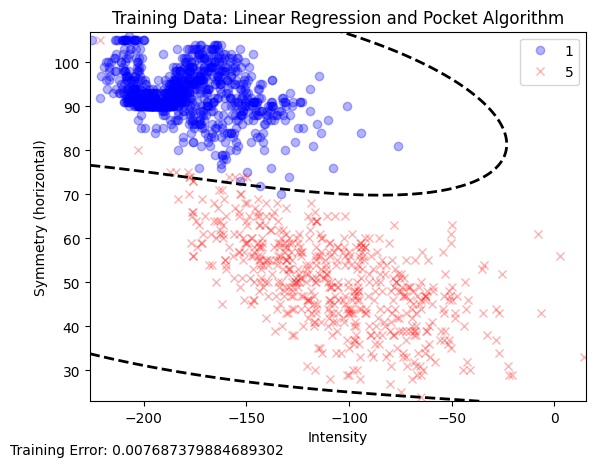

C:\Users\huang\AppData\Local\Temp\ipykernel_41900\1477967418.py:159: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='dashed', linewidths=2, label='Decision boundary')


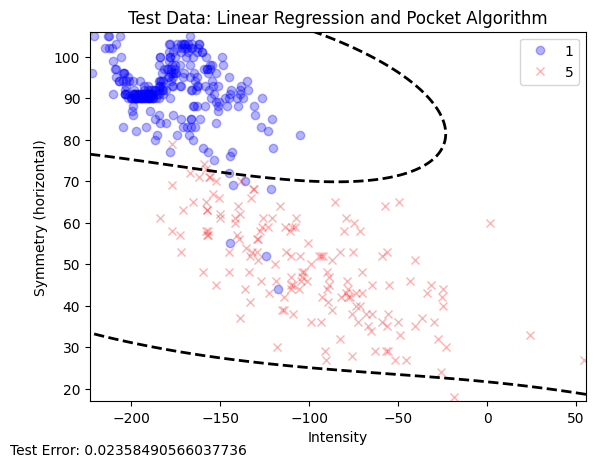

In [17]:
dfTrainPoly, polyTrain = polyTrans(dfTrain, 3)
dfTestPoly, polyTest = polyTrans(dfTest, 3)

# Lin Reg -> Pocket
trainWeight, trainCorrect, trainUpdates = pocketPoly(linRegPoly(dfTrainPoly), dfTrainPoly, 10000)
Etrain = error(dfTrainPoly['x'].size, trainCorrect)
testCorrect = testingPoly(dfTestPoly, trainWeight)
Etest = error(dfTestPoly['x'].size, testCorrect)

plottingPoly(dfTrain, False, Etrain, "Training Data: Linear Regression and Pocket Algorithm", trainWeight, "LinRegPocketTrain2", polyTrain)
plottingPoly(dfTest, True, Etest, "Test Data: Linear Regression and Pocket Algorithm", trainWeight, "LinRegPocketTest2", polyTrain)

C:\Users\huang\AppData\Local\Temp\ipykernel_41900\1477967418.py:159: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='dashed', linewidths=2, label='Decision boundary')


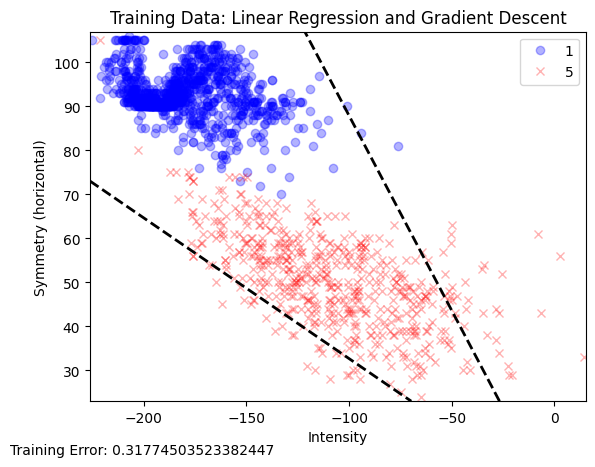

C:\Users\huang\AppData\Local\Temp\ipykernel_41900\1477967418.py:159: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='dashed', linewidths=2, label='Decision boundary')


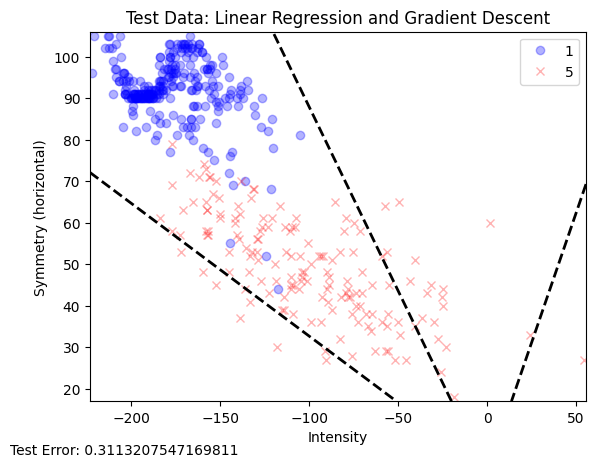

In [25]:
# Lin Reg -> Gradient 
trainWeight, trainCorrect = gradientPoly(linRegPoly(dfTrainPoly), dfTrainPoly, 5000, .000001)
Etrain = error(dfTrainPoly['x'].size, trainCorrect)
testCorrect = testingPoly(dfTestPoly, trainWeight)
Etest = error(dfTestPoly['x'].size, testCorrect)

plottingPoly(dfTrain, False, Etrain, "Training Data: Linear Regression and Gradient Descent", trainWeight, "LinRegGradientTrain2", polyTrain)
plottingPoly(dfTest, True, Etest, "Test Data: Linear Regression and Gradient Descent", trainWeight, "LinRegGradientTest2", polyTrain)

C:\Users\huang\AppData\Local\Temp\ipykernel_41900\1477967418.py:159: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='dashed', linewidths=2, label='Decision boundary')


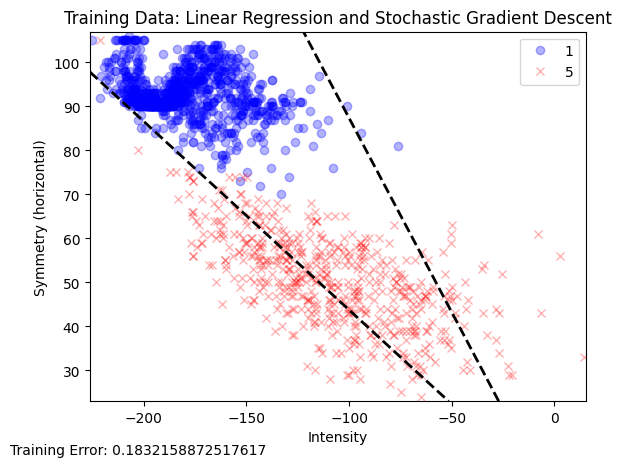

C:\Users\huang\AppData\Local\Temp\ipykernel_41900\1477967418.py:159: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='dashed', linewidths=2, label='Decision boundary')


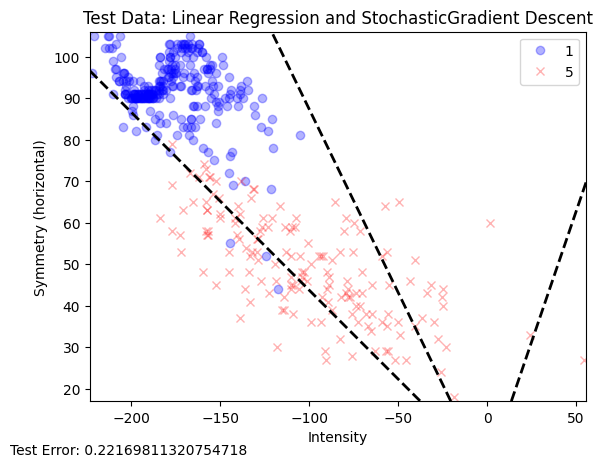

In [31]:
# Lin Reg -> Stocastic
trainWeight, trainCorrect = stochasticPoly(linRegPoly(dfTrainPoly), dfTrainPoly, 10000, .000001)
Etrain = error(dfTrainPoly['x'].size, trainCorrect)
testCorrect = testingPoly(dfTestPoly, trainWeight)
Etest = error(dfTestPoly['x'].size, testCorrect)

plottingPoly(dfTrain, False, Etrain, "Training Data: Linear Regression and Stochastic Gradient Descent", trainWeight, "LinRegStochasticTrain2", polyTrain)
plottingPoly(dfTest, True, Etest, "Test Data: Linear Regression and StochasticGradient Descent", trainWeight, "LinRegStochasticTest2", polyTrain)

C:\Users\huang\AppData\Local\Temp\ipykernel_41900\3223663836.py:159: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='dashed', linewidths=2, label='Decision boundary')


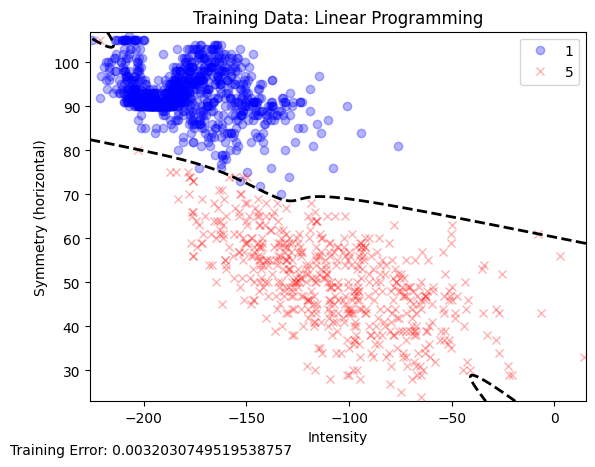

C:\Users\huang\AppData\Local\Temp\ipykernel_41900\3223663836.py:159: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='dashed', linewidths=2, label='Decision boundary')


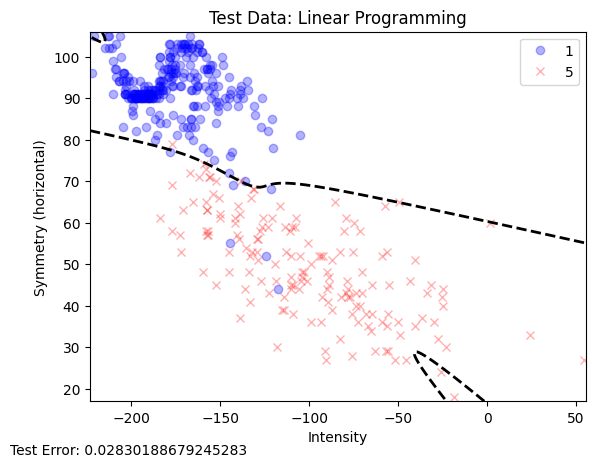

E_train Out-of-sample Error Bound: 0.03757713112845076
E_test Out-of-sample Error Bound: 0.0942571268866946


In [46]:
# Linear Program
trainWeight, trainCorrect = linProgramPoly(dfTrainPoly)
Etrain = error(dfTrainPoly['x'].size, trainCorrect)
testCorrect = testingPoly(dfTestPoly, trainWeight)
Etest = error(dfTestPoly['x'].size, testCorrect)

plottingPoly(dfTrain, False, Etrain, "Training Data: Linear Programming", trainWeight, "LinProgTrain2", polyTrain)
plottingPoly(dfTest, True, Etest, "Test Data: Linear Programming", trainWeight, "LinProgTest2", polyTrain)

#Still has the smallest errors
Eout1 = hoeff(Etrain, dfTrain['x'].size)
Eout2 = hoeff(Etest, dfTest['x'].size)
print(f"E_train Out-of-sample Error Bound: {Eout1}")
print(f"E_test Out-of-sample Error Bound: {Eout2}")

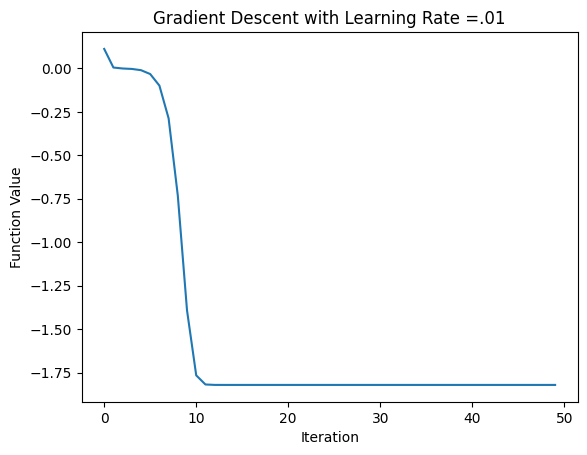

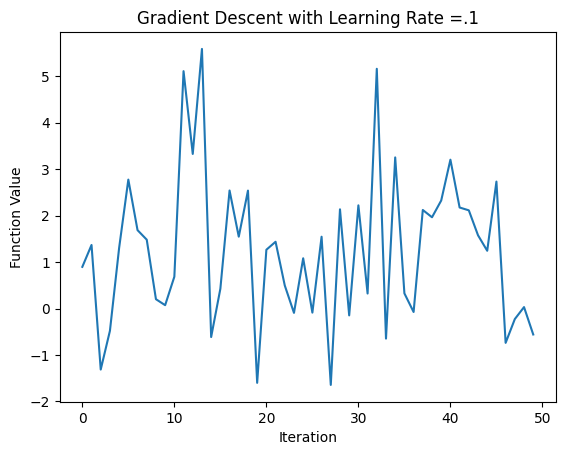

In [10]:
# Question 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

# initial values x =.1, y=.1, n = .01, max = 50

def func(x, y):
    return x**2 + 2*y**2 + (2*math.sin(2*math.pi*x)*math.sin(2*math.pi*y))
#print(func(.1, .1))

def gradFunc(x, y, maxUpdates, rate):
    updates = []
    for i in range(maxUpdates):
        dfdx = 2 * x + 4 * math.pi * math.cos(2 * math.pi * x) * math.sin(2 * math.pi * y)
        dfdy = 4 * y + 4 * math.pi * math.sin(2 * math.pi * x) * math.cos(2 * math.pi * y)
        x -= rate * dfdx
        y -= rate * dfdy
        updates.append((i, x, y, func(x, y)))
    return x, y, func(x, y), updates

def gradPlot(updates, title, save):
    iterations = [step[0] for step in updates]
    values = [step[3] for step in updates]

    plt.plot(iterations, values)
    plt.xlabel('Iteration')
    plt.ylabel('Function Value')
    plt.title(title)
    plt.savefig(save)
    plt.show()

In [ ]:
# Part A
x, y, f, updates = gradFunc(.1, .1, 50, .01)
gradPlot(updates, "Gradient Descent with Learning Rate =.01", "SmallerRate")

x, y, f, updates = gradFunc(.1, .1, 50, .1)
gradPlot(updates, "Gradient Descent with Learning Rate =.1", "SmallRate")

In [9]:
# Part B
inputs = np.array([[.1,.1], [1,1], [-.5,-.5], [-1,-1]])
rates = [.01, .1]

for rate in rates:
    for coor in inputs:
        x, y, f, updates = gradFunc(coor[0], coor[1], 50, rate)
        print(f"Input {coor} for rate {rate}")
        print(f"Min Location: {x}, {y}")
        print(f"Min Value: {f}")

Input [0.1 0.1] for rate 0.01
Min Location: 0.24380496936478835, -0.23792582148617766
Min Value: -1.8200785415471563
Input [1. 1.] for rate 0.01
Min Location: 1.2180703013110816, 0.7128119506017776
Min Value: 0.5932693743258357
Input [-0.5 -0.5] for rate 0.01
Min Location: -0.7313774604138037, -0.23785536290157222
Min Value: -1.3324810623309777
Input [-1. -1.] for rate 0.01
Min Location: -1.2180703013110816, -0.7128119506017776
Min Value: 0.5932693743258357
Input [0.1 0.1] for rate 0.1
Min Location: 0.348357019225074, -0.06958226018796704
Min Value: -0.5591459311689072
Input [1. 1.] for rate 0.1
Min Location: 0.19845949678932556, 0.4578244085275386
Min Value: 0.9551781125265671
Input [-0.5 -0.5] for rate 0.1
Min Location: -0.5779200088075318, 1.4629557170858447
Min Value: 4.831411100483904
Input [-1. -1.] for rate 0.1
Min Location: -0.19845949678932556, -0.4578244085275386
Min Value: 0.9551781125265671
